## Задание 2

In [14]:
from clickhouse_driver import connect
import pandas as pd
import json

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import chart_studio.plotly as py
import cufflinks
cufflinks.go_offline()

In [5]:
# данные для коннекта

def load_credentials(path):
    global credentials
    try:
        credentials = json.loads(open(path).read())
    except FileNotFoundError:
        raise FileNotFoundError("File with credentials not found")

In [3]:
load_credentials("credentials.json")

In [6]:
# функция для выполнения запроса к Clickhouse

def get_data(sql):
    con = connect(user = credentials["user"], 
                  password = credentials["password"],
                  host = credentials["host"], 
                  database = credentials["database"], 
                  port = credentials["port"])
    cursor = con.cursor()
    query = cursor.execute(sql)
    columns = [i[0] for i in cursor.description]
    return pd.DataFrame(cursor.fetchall(), columns=columns)

In [33]:
# подсчет когортного ARPU

def get_cohort_ARPU(agg="toDate"):
    """
    Counting ARPU
    ----------
    Parameters
    ----------
    agg : String
          aggregation type, 
          3 variants available: "toDate", "toStartOfWeek", "toStartOfMonth"
    """
    
    if agg == "toStartOfMonth":
        diff = "month"
    elif agg == "toStartOfWeek":
        diff = "week"
    else:
        diff = "day"
        
    sql = """SELECT {}(installed_at) as installed_date,
                    {}(created_at) as date,
                    dateDiff('{}', installed_date, date) as diff,
                    uniqExact(user_id) as users,
                    sum(reporting_revenue) as revenue,
                    round(revenue/users, 2) as arpu
            FROM marvel
            GROUP BY installed_date, date
            ORDER BY installed_date, date""".format(agg, agg, diff)
    df = get_data(sql)
    cohort_df = df.pivot_table(index = 'installed_date', columns = 'diff', values = 'arpu')
    
    return cohort_df

In [40]:
# подсчет когортного Retention

def get_cohort_Retention(agg="toDate"):
    """
    Counting Retention
    ----------
    Parameters
    ----------
    agg : String
          aggregation type, 
          3 variants available: "toDate", "toStartOfWeek", "toStartOfMonth"
    """
    
    if agg == "toStartOfMonth":
        diff = "month"
    elif agg == "toStartOfWeek":
        diff = "week"
    else:
        diff = "day"
        
    sql = """
            SELECT a.installed_date as installed_date,
                    diff,
                    cohort_users, 
                    users, 
                    round(users/cohort_users, 3) as retention
            FROM (
                SELECT {}(installed_at) as installed_date,
                        {}(created_at) as date,
                        dateDiff('{}', installed_date, date) as diff,
                        uniqExact(user_id) as users
                FROM marvel
                GROUP BY installed_date, date
                ORDER BY installed_date, date
            ) a INNER JOIN (
                SELECT {}(installed_at) as installed_date,
                        uniqExact(user_id) as cohort_users
                FROM marvel
                WHERE toStartOfMonth(installed_at) == toStartOfMonth(created_at)
                GROUP BY installed_date
            ) b
            USING installed_date
             """.format(agg, agg, diff, agg)
    df = get_data(sql)
    cohort_df = df.pivot_table(index = 'installed_date', columns = 'diff', values = 'retention')
    
    return cohort_df

In [9]:
def cohort_plot(df):
    with sns.axes_style("white"):
        fig, ax = plt.subplots(1, 2, figsize=(24, 16), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

        sns.heatmap(df, 
                    mask=df.isnull(), 
                    annot=True, 
                    fmt='.3g', 
                    cmap='RdYlGn', 
                    ax=ax[1])
        ax[1].set_title('Cohorts', fontsize=16)
        ax[1].set(xlabel='# of periods',
                  ylabel='')

        # cohort size
        cohort_size = df.iloc[:,0]
        cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
        white_cmap = mcolors.ListedColormap(['white'])
        sns.heatmap(cohort_size_df, 
                    annot=True, 
                    cbar=False, 
                    fmt='g', 
                    cmap=white_cmap, 
                    ax=ax[0])

        fig.tight_layout()

In [31]:
# подсчет APRU

def get_ARPU(agg="toDate"):
    """
    Counting ARPU
    ----------
    Parameters
    ----------
    agg : String
          aggregation type, 
          3 variants available: "toDate", "toStartOfWeek", "toStartOfMonth"
    """
    sql = """SELECT {}(created_at) as date,
                    uniqExact(user_id) as users,
                    sum(reporting_revenue) as revenue,
                    round(revenue/users, 2) as arpu
            FROM marvel
            GROUP BY date
            ORDER BY date""".format(agg)
    df = get_data(sql).set_index('date')
    
    # draw plot
    df[['arpu']].iplot(y='arpu', mode='lines+markers', xTitle='date')
    
    return df

## Результаты

In [34]:
# Когортный ARPU по месяцам

arpu_month = get_cohort_ARPU(agg="toStartOfMonth")
arpu_month

diff,0,1,2,3,4,5,6
installed_date,,,,,,,
2019-12-01,NaN,231.17,43.16,57.81,81.77,24.97,24.28
2020-01-01,67.22,15.20,48.32,21.78,19.92,21.83,NaN
2020-02-01,11.97,11.52,12.36,14.46,20.48,13.53,NaN
2020-03-01,1.07,0.25,0.75,1.49,0.58,NaN,NaN
2020-04-01,0.14,0.11,0.13,0.03,NaN,NaN,NaN
2020-05-01,0.16,0.21,0.05,NaN,NaN,NaN,NaN
2020-06-01,0.44,0.07,NaN,NaN,NaN,NaN,NaN
2020-07-01,0.16,NaN,NaN,NaN,NaN,NaN,NaN


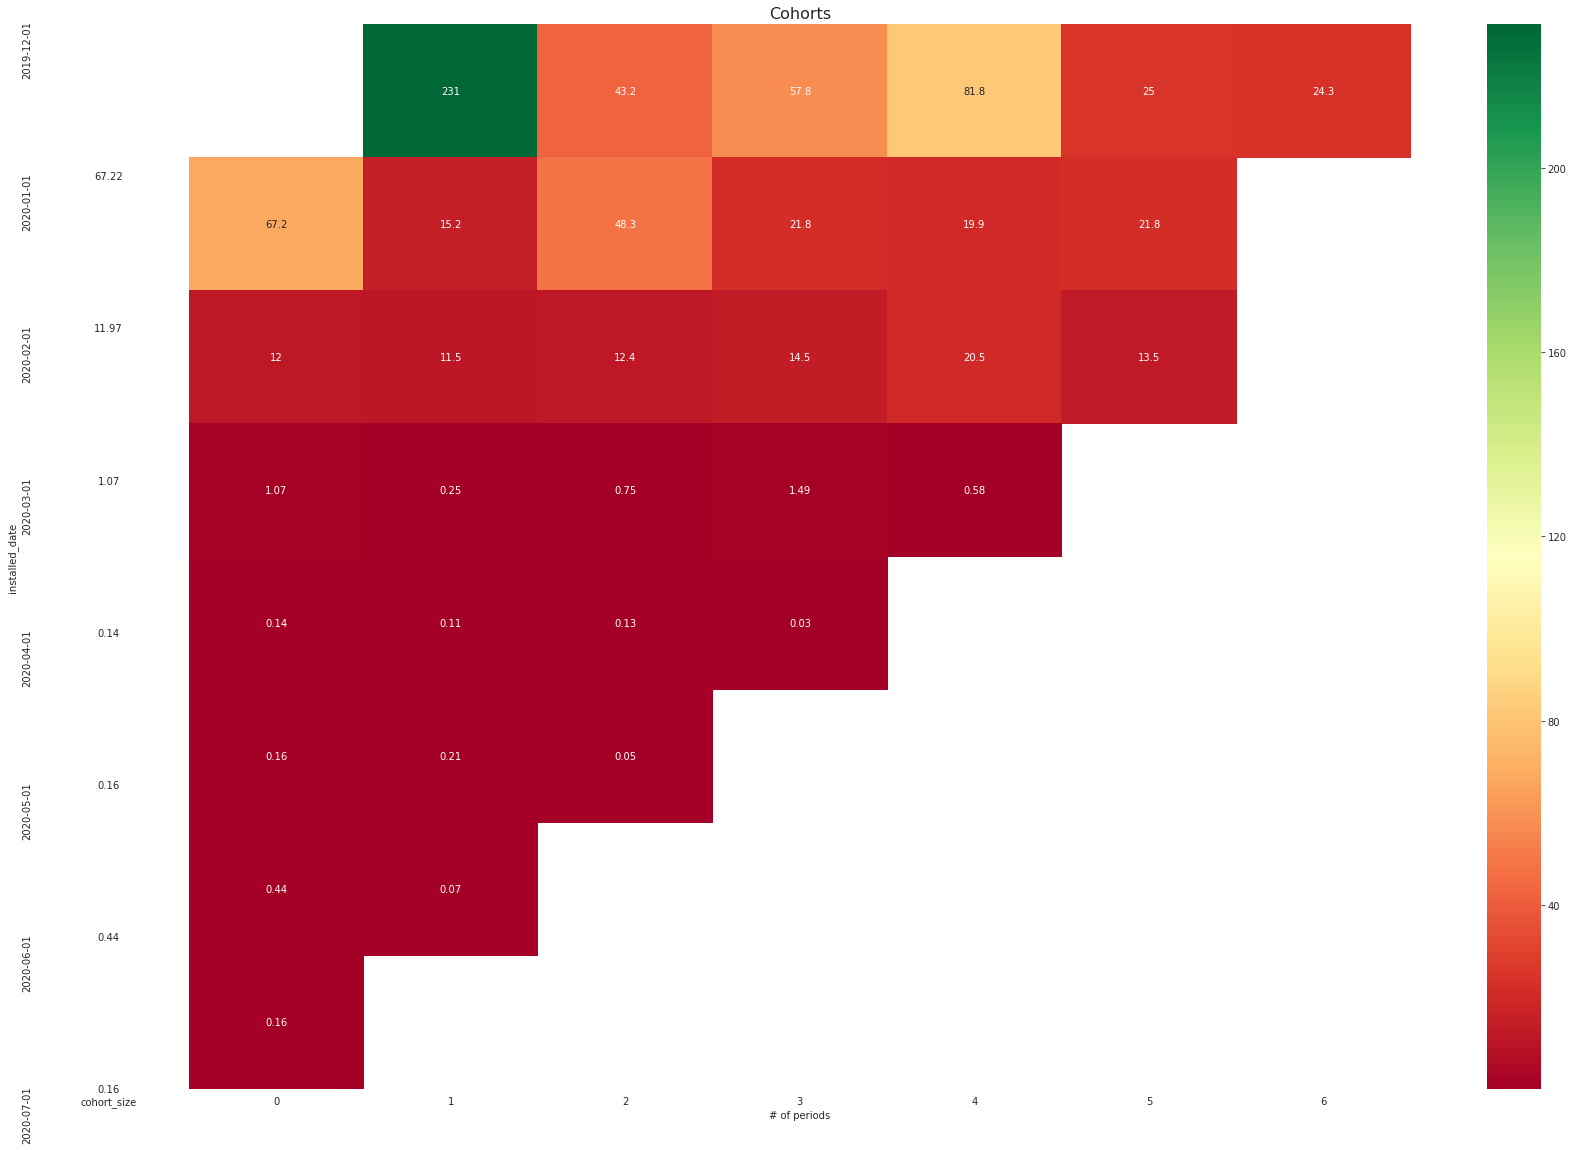

In [86]:
# Когортный ARPU по месяцам в виде heatmap
cohort_plot(arpu_month)

# 1. Отсутствуют данные по сессиям за декабрь 2019 года и половину января 2020 года
# 2. Начиная с марта когорты резко снизились по значению ARPU с 12 до значений около и ниже 1.
# 3. Январские пользователи в марте резко принесли ARPU = 48.32 (более чем в 2 раза больше чем в другие месяцы)
# 4. У февральских пользователей тоже есть выброс в июне.

In [36]:
# Когортный ARPU по неделям

arpu_week = get_cohort_ARPU(agg="toStartOfWeek")
arpu_week

diff,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
installed_date,,,,,,,,,,,,,,,,,,,,,
2019-12-15,NaN,NaN,NaN,NaN,143.95,876.15,53.86,5.68,23.09,38.72,...,12.46,125.73,NaN,NaN,46.67,26.08,18.00,18.75,34.60,35.09
2019-12-22,NaN,NaN,NaN,NaN,6.49,13.06,31.17,12.90,8.50,NaN,...,NaN,9.00,13.47,9.99,10.46,36.22,10.08,17.56,17.43,23.55
2019-12-29,NaN,NaN,NaN,NaN,8.50,NaN,NaN,40.98,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.99,NaN,41.97,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-12,NaN,5.97,168.95,126.67,5.97,11.83,79.42,1.99,532.86,33.87,...,32.28,33.04,NaN,34.44,NaN,33.80,NaN,NaN,NaN,NaN
2020-01-19,18.86,8.39,11.68,26.12,6.95,5.64,7.81,4.90,6.75,6.37,...,14.76,16.62,22.54,14.54,20.46,8.94,NaN,NaN,NaN,NaN
2020-01-26,76.40,9.61,10.31,17.55,10.50,6.37,5.68,8.29,7.12,5.99,...,15.87,16.31,17.34,30.50,18.07,NaN,NaN,NaN,NaN,NaN
2020-02-02,11.40,10.45,9.14,9.93,9.87,9.30,7.08,10.05,8.44,9.41,...,22.91,18.00,16.17,19.89,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-09,10.31,10.18,8.29,7.82,9.24,9.84,8.88,10.08,7.52,10.82,...,16.22,19.10,17.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN


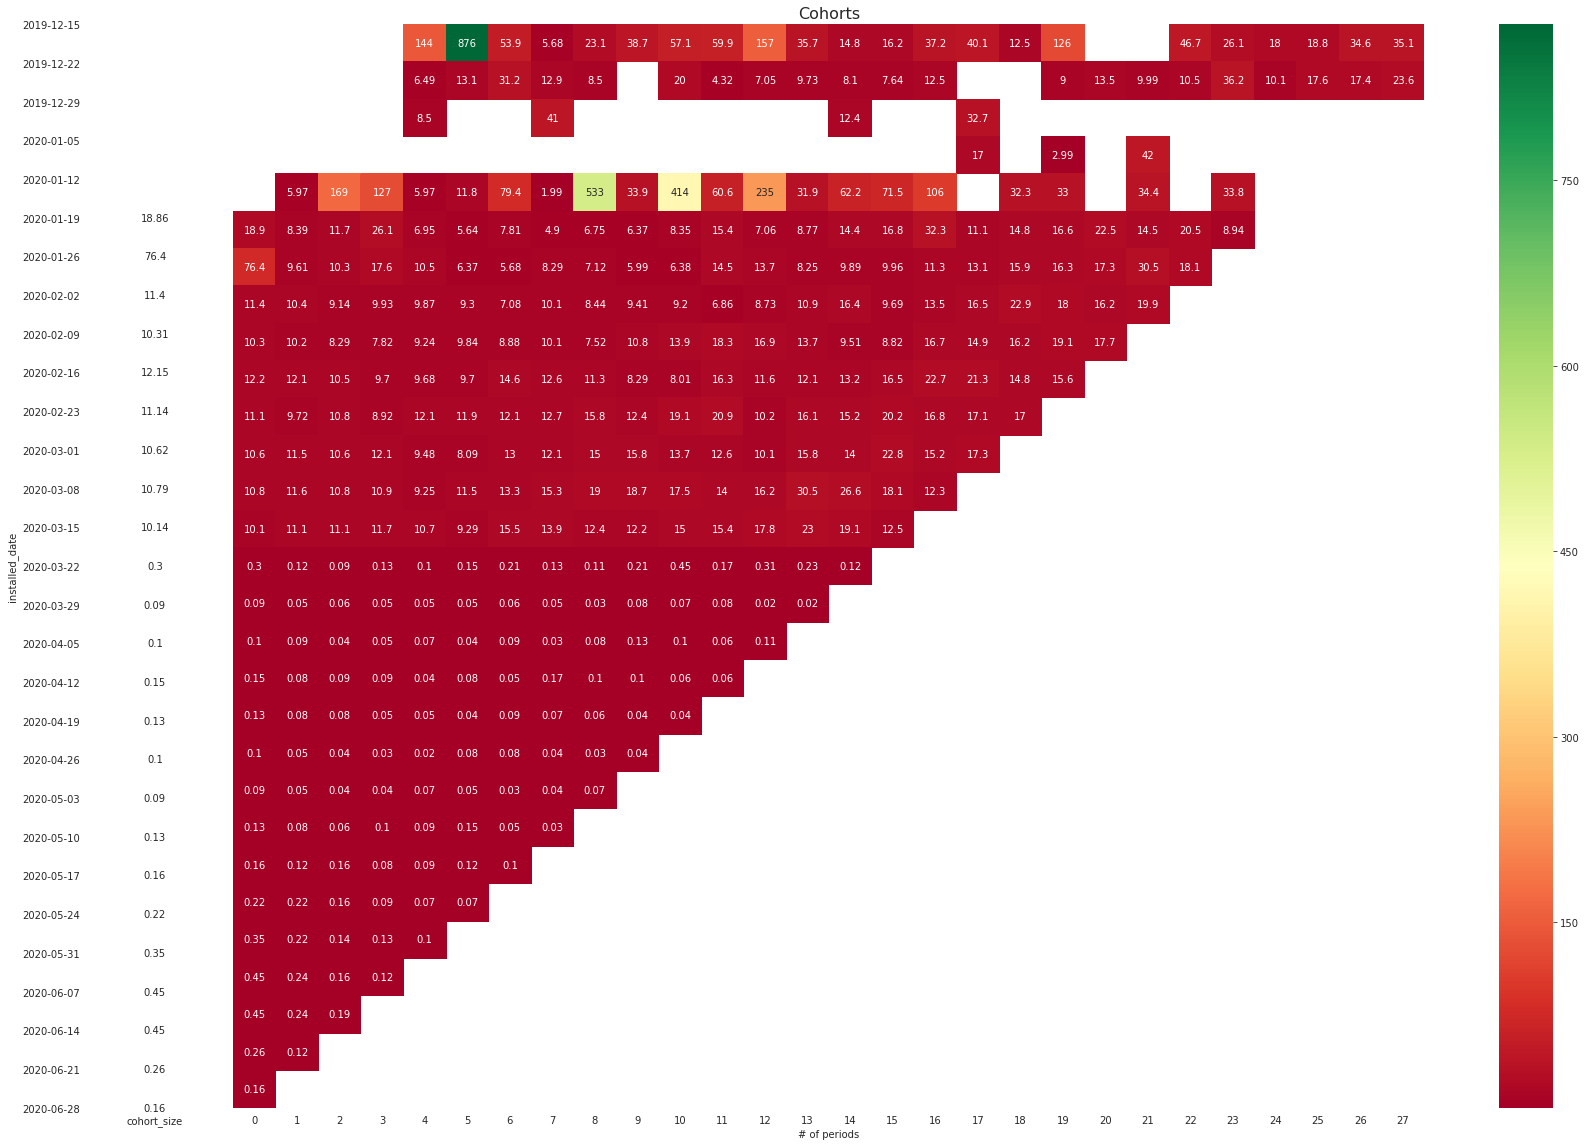

In [37]:
# Когортный ARPU по неделям в виде heatmap
cohort_plot(arpu_week)

In [38]:
# Когортный ARPU по дням

arpu_day = get_cohort_ARPU(agg="toDate")
arpu_day

diff,0,1,2,3,4,5,6,7,8,9,...,172,174,181,182,184,185,186,187,189,190
installed_date,,,,,,,,,,,,,,,,,,,,,
2019-12-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,16.64,17.96,9.41,25.68
2019-12-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-27,0.18,0.10,0.06,0.07,0.05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-28,0.17,0.06,0.02,0.02,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-29,0.14,0.06,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
# Когортный Retention по месяцам

retention_month = get_cohort_Retention(agg="toStartOfMonth")
retention_month

diff,0,1,2,3,4,5
installed_date,,,,,,
2020-01-01,1.0,0.444,0.151,0.182,0.457,0.324
2020-02-01,1.0,0.279,0.054,0.102,0.100,0.002
2020-03-01,1.0,0.575,0.112,0.058,0.004,NaN
2020-04-01,1.0,0.256,0.072,0.005,NaN,NaN
2020-05-01,1.0,0.220,0.010,NaN,NaN,NaN
2020-06-01,1.0,0.098,NaN,NaN,NaN,NaN
2020-07-01,1.0,NaN,NaN,NaN,NaN,NaN


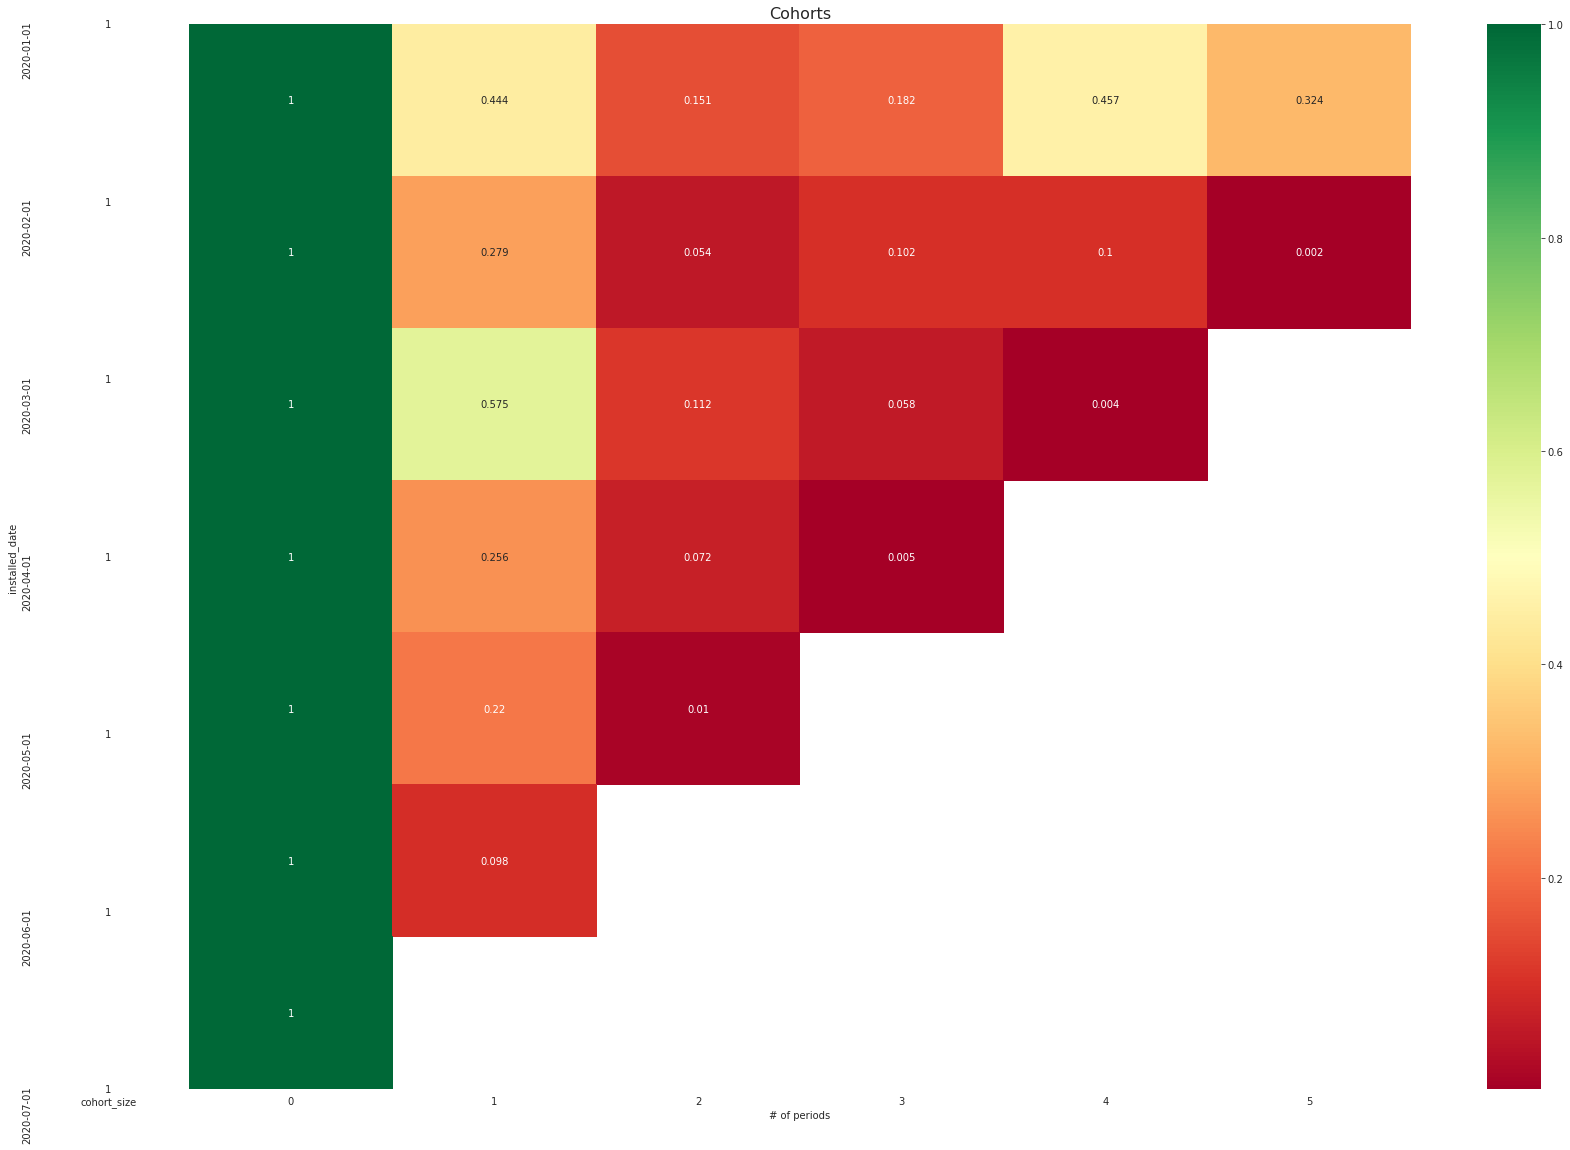

In [87]:
# Когортный Retention по месяцам в виде heatmap
cohort_plot(retention_month)


# 1. Январская когорта имеет резкий скачок после апреля
# 2. По сравнению с остальными месяцами, когорта марта имеет высокий ретеншн следующего месяца.
# 3. После второго месяца ретенш падает до значений 7-12%

In [88]:
# Когортный Retention по неделям

retention_week = get_cohort_Retention(agg="toStartOfWeek")
retention_week

diff,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
installed_date,,,,,,,,,,,,,,,,,,,,,
2020-01-12,NaN,0.500,0.500,1.000,0.500,1.500,0.500,0.500,1.000,1.500,...,0.500,0.500,1.500,NaN,0.500,0.500,NaN,0.500,NaN,0.500
2020-01-19,0.613,0.443,0.085,0.038,0.057,0.047,0.047,0.047,0.019,0.009,...,0.160,0.151,0.132,0.236,0.132,0.160,0.123,0.104,0.104,0.028
2020-01-26,0.789,0.375,0.103,0.111,0.056,0.038,0.035,0.026,0.026,0.018,...,0.094,0.091,0.094,0.085,0.100,0.085,0.079,0.029,0.012,NaN
2020-02-02,0.668,0.287,0.131,0.053,0.052,0.028,0.031,0.013,0.013,0.013,...,0.031,0.039,0.044,0.045,0.045,0.036,0.021,0.014,NaN,NaN
2020-02-09,0.640,0.356,0.111,0.068,0.044,0.027,0.036,0.016,0.012,0.021,...,0.035,0.028,0.031,0.034,0.028,0.015,0.006,NaN,NaN,NaN
2020-02-16,0.822,0.262,0.125,0.061,0.045,0.039,0.020,0.012,0.012,0.014,...,0.032,0.032,0.025,0.021,0.019,0.006,NaN,NaN,NaN,NaN
2020-02-23,1.000,0.369,0.128,0.064,0.069,0.029,0.018,0.022,0.009,0.014,...,0.032,0.030,0.021,0.016,0.009,NaN,NaN,NaN,NaN,NaN
2020-03-01,0.783,0.229,0.074,0.052,0.023,0.009,0.014,0.008,0.013,0.012,...,0.013,0.014,0.015,0.008,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-08,0.797,0.227,0.096,0.037,0.017,0.020,0.014,0.018,0.014,0.010,...,0.010,0.009,0.004,NaN,NaN,NaN,NaN,NaN,NaN,NaN


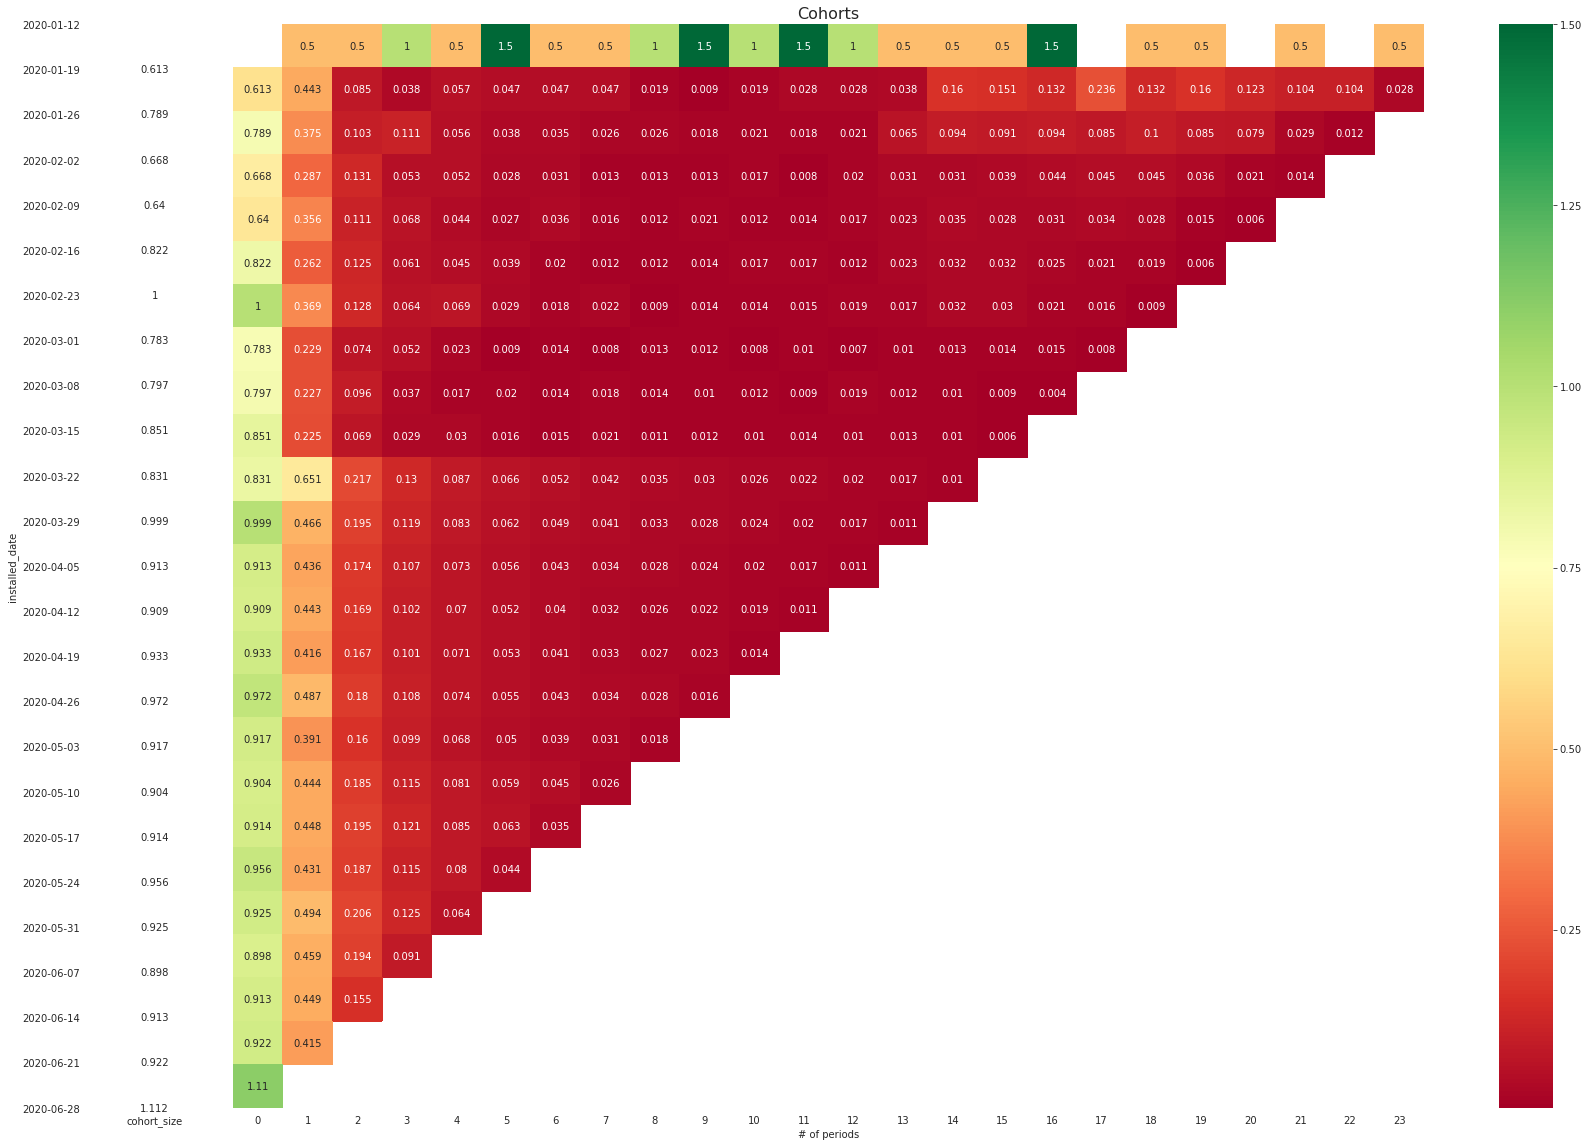

In [89]:
# Когортный Retention по неделям в виде heatmap
cohort_plot(retention_week)

In [90]:
# Когортный Retention по дням

retention_day = get_cohort_Retention(agg="toDate")
retention_day

diff,0,1,2,3,4,5,6,7,8,9,...,150,151,152,153,155,156,157,158,159,161
installed_date,,,,,,,,,,,,,,,,,,,,,
2020-01-16,NaN,NaN,NaN,NaN,0.500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5
2020-01-22,0.500,0.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-23,0.367,0.467,0.233,0.100,0.033,NaN,0.033,0.067,NaN,NaN,...,NaN,0.033,NaN,NaN,NaN,0.067,0.033,0.033,0.033,NaN
2020-01-24,0.413,0.239,0.196,0.065,0.109,0.109,0.043,0.043,0.043,0.065,...,NaN,0.022,0.043,NaN,0.022,NaN,NaN,NaN,NaN,NaN
2020-01-25,0.321,0.214,0.250,0.107,0.107,0.036,0.036,NaN,NaN,NaN,...,NaN,NaN,0.036,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-27,0.631,0.702,0.392,0.265,0.195,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-28,0.640,0.702,0.412,0.279,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-29,0.664,0.741,0.424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
# случайно сделала подсчет ARPU без когорт, пусть останется

arpu = get_ARPU()